# Importations

In [2]:
import numpy as np
import csv
import gc
import re
import matplotlib.pyplot as plt
from collections import Counter


In [3]:
#pour savoir quelle question correspond à quel numéro 
def question() : 
  l = []
  l.append('Titre')
  l.append('Quel est aujourdhui pour vous le problème concret le plus important dans le domaine de lenvironnement')
  l.append('que faudrait-il faire pour apporter reponses au probleme le plus important dans le domaine environnement (suit question1)')
  l.append('vie quotidienne impactée par changement climatique ? ')
  l.append('quelle maniere vie quotidienne impactée changement climatique')
  l.append('pensez-vous pouvoir contribuer à protéger environnement')
  l.append('que faites vous aujourdhui pr environnement/ que pourriez vous faire')
  l.append('questce qui peut vous inciter à changer comportement (ex chauffage, conduire, voiture courte distance')
  l.append('solutions plus simples; plus supportables financierement pr inciter changer comportement')
  l.append('par rapprt mode de chauffage actuel, pensez vous solutions alternatives plus écolo ? ')
  l.append('que faut il faire pour vous faire changer mode de chauffage')
  l.append('possibiité recourir mobilité alternative à voiture individuelle ?')
  l.append('que faire pour vous convaincre pas utiliser voiture QCM')
  l.append('quelles solutions mobilité alternatives aimerez vous utiliser (si yen avait)')
  l.append('qui doit se charger proposer mobilité alternatives')
  l.append('que faire france partager ses choix environnement niveau européen, international')
  l.append('autre points ?')
  
  return(l)


questions = question()

# Lecture des données

In [4]:
def column(matrix, i):
    return [row[i] for row in matrix]
def sort_dictionary(dictionary):
    '''returns a sorted dictionary (as tuples) based on the value of each key'''
    return sorted(dictionary.items(), key=lambda x: x[1], reverse=True)

def normalize_counts(counts):
    '''returns the frequency of tokens for each text'''
    total = sum(counts.values())
    return dict((word, float(count)/total) for word,count in counts.items())
  
def read_data(filename,yes_no_array,by_frequency=True):
    '''return an array of cleaned data from a csv file made by the write_data function.
    The order of the columns is the following: 
    Title | Category of the participant | Questions | Output
    INPUT: name of the file, position of the integer columns
    OUTPUT: matrix of data'''
    data = []
    with open(filename, newline='',encoding='utf-8') as f:
        reader = csv.reader(f, delimiter=';')
        for row in reader:
            element = []
            for i in range(len(row)-1):
              if i in yes_no_array:
                element.append(int(row[i]))
              elif by_frequency is True:
                element.append(normalize_counts(read_dictionary(row[i])))
              else:
                element.append(read_dictionary(row[i]))
            element.append(row.pop())
            data.append(element)
        #  call the garbage collector
        gc.collect()
    return data

def read_word_count(filename):
    '''This function reads a file which contains arrays of tuples of key and number of occurrences
    of a word, and returns an array of dictionaries with the tuples
    INPUT: name of the file to upload
    OUTPUT: dictionnary with the words of the file'''
    words = []
    with open(filename, newline='',encoding='utf-8') as f:
        reader = csv.reader(f, delimiter=';')
        for row in reader:
            dictionary = dict()
            for i in row:
                dictionary.update(read_dictionary(i))
            words.append(dictionary)
        #  call the garbage collector
        gc.collect()
    return words

def read_dictionary(dictionary_string):
    '''return a dictionary from a string 
    INPUT: an string of many key-value tuples
    OUTPUT: a dictionary'''
    dictionary = dict()
    clean_dict = re.sub(r'[ \[ | \] | \( | \) | \' | { | } ]','', dictionary_string)
    parsed_dict = re.split(r'[,|:]', clean_dict)
    for i in range(int(len(parsed_dict)/2)):
        key = parsed_dict[2*i]
        value = int(parsed_dict[2*i+1])
        dictionary[key] = value
    return dictionary



## Ajout de l'output et calcul des mots les plus utilisés

In [5]:
def find_zip_codes_by_town(density_threshold,filename='city_information.tsv'):
    '''This function splits up the zip codes of a file into two categories according to a density threshold
    INPUT: density threshold, file name of the reference library
    OUTPUT: set of zip codes for cities, a set of zip codes for villages'''
    codes_cities = set()
    tmp_code_cities = set()
    codes_villages = set()
    tmp_code_villages = set()
    with open(filename, newline='',encoding='utf-8') as f:
        reader = csv.reader(f, delimiter='\t')
        next(reader)
        for row in reader:
            # We keep only the questions with a valid ID and a valid number of rows
            density = -1
            if row[3] != '' and row[4] != '':
                density = float(row[3]) / float(row[4])
            if density >= density_threshold:
                codes_cities.add(row[1])
            elif density != -1: codes_villages.add(row[1])
    tmp_code_cities = codes_cities.copy()
    tmp_code_villages = codes_villages.copy()
    for code in tmp_code_cities:
        match = re.search('-',code)
        if (match != None):
            codes_cities.remove(code)
            split_codes = re.split('-', code)
            for i in split_codes:
                codes_cities.add(i)
    for code in tmp_code_villages:
        match = re.search('-',code)
        if (match != None):
            codes_villages.remove(code)
            split_codes = re.split('-', code)
            for i in split_codes:
                codes_villages.add(i)
    #  call the garbage collector
    gc.collect()
    return codes_cities,codes_villages

def city_village_classifier(density_threshold,data):
    '''This function tags the entries of a data set according to their population density. If it is more than
    a given threshold, the label is 1, -1 otherwise
    INPUT: the density threshold, a dataset
    OUTPUT: the classified dataset'''
    city_zip_codes , village_zip_codes = find_zip_codes_by_town(density_threshold)
    classified_data = []
    class_vector = []
    for entry in data:
        if entry[-1] in city_zip_codes:
            classified_data.append(entry)
            class_vector.append(1)
        elif entry[-1] in village_zip_codes: 
            classified_data.append(entry)
            class_vector.append(-1)
    classified_data = np.array(classified_data)
    classified_data = np.delete(classified_data,len(classified_data[0])-1,1)
    class_vector = np.array(class_vector).reshape((len(class_vector),1))
    classified_data = np.append(classified_data,class_vector,axis=1)
    #  call the garbage collector
    gc.collect()
    return classified_data

In [6]:
def word_count_by_question(data,yes_no_questions):
    '''This function counts all the words of a data set by question(column) and arrange them into a dictionnary
    INPUT:  dataset, the numbers columns of integers
    OUTPUT: an array of dictionaries of the counted words
    '''
    word_count = []    
    for i in range(len(data[0])-1):
        if i not in yes_no_questions:
            word_count.append(Counter())
    j = 0
    for i in range(len(data[0])-1):
        if i not in yes_no_questions:
            for entry in column(data,i): word_count[j] += Counter(entry)
            j += 1
    #  call the garbage collector
    gc.collect()
    return word_count
  

def word_count_total(dictionary_array):
    '''This functions sums up all the words of a many texts represented by dictionaries
    INPUT: an array of dictionaries
    OUTPUT a dictionary with the count of all the words:
    '''
    total_words = Counter()
    for question in dictionary_array: total_words += Counter(question)
    return total_words



In [7]:
def get_most_used_words(data, yes_no_array, word_count_array, number_of_words):
    '''This function compares for each entry and question the number of ocurrences of the most used
    words in the respective question. This function limits the number of most used words in order to normalized
    the output
    INPUT: a data set, the answers whose response is an integer, an array with the total of words by questions
    the maximum number of words to keep, 
    OUTPUT: the filtered dataset
    '''
    most_used_words = []
    for question in word_count_array:
        words_by_question = []
        sorted_word_array = sort_dictionary(question)
        for i in range(number_of_words):
            words_by_question.append(sorted_word_array[i])
        most_used_words.append(words_by_question)
    
    filtered_data = []
    
    for entry in data:
        entry_array = []
        j = 0
        for i in range(len(entry)-1):
            if i in yes_no_array:
                entry_array.append(entry[i])
            else:
                words_rep_array = []
                for word in most_used_words[j]:
                    try:
                        words_rep_array.append(entry[i][word[0]])
                    except KeyError as error:
                        words_rep_array.append(0)
                entry_array.append(words_rep_array)
                j += 1
        entry_array.append(entry[-1])
        filtered_data.append(entry_array)
    
    #  call the garbage collector
    gc.collect()
        
    return filtered_data

def get_set_features(data,column):
    '''This function return a feature (column) of a dataset
    '''
    a_data = np.array(data)
    features = a_data[:,column]
    features = np.array([np.asarray(i) for i in features])
    return features

def get_total_most_used_words(data, yes_no_array, word_count_array, number_of_words,by_question=True):
    '''This function compares for each entry and question the number of ocurrences of the most used
    words in the respective question. This function limits the number of most used words in order to normalized
    the output
    INPUT: a data set, the answers whose response is an integer, an array with the total number of words
    the maximum number of words to keep, 
    OUTPUT: the filtered dataset
    '''
    most_used_words = []
    sorted_word_array = sort_dictionary(word_count_array)
    for i in range(number_of_words):
        most_used_words.append(sorted_word_array[i])
    
    filtered_data = []
    for entry in data:
        entry_array = []
        j = 0
        entry_words = word_count_by_question([entry],yes_no_array)
        entry_words= word_count_total(entry_words)
        words_rep_array = []
        for word in most_used_words:
            try:
                words_rep_array.append(entry_words[word[0]])
            except KeyError as error:
                words_rep_array.append(0)
        entry_array.append(words_rep_array)
        j += 1
        entry_array.append(entry[-1])
        filtered_data.append(entry_array)

    #  call the garbage collector
    gc.collect()
        
    return filtered_data
  
def get_name_most_used_words(word_dictonary, word_number):
  words = []
  sorted_words = sort_dictionary(word_dictonary)
  for i in range(word_number):
    words.append(sorted_words[i][0])
  return words

def get_word_and_count(word_dictonary, word_number):
  words = []
  counts = []
  sorted_words = sort_dictionary(word_dictonary)
  for i in range(word_number):
    words.append(sorted_words[i][0])
    counts.append(sorted_words[i][1])
  return words, counts
      

In [8]:
# exemple
yes_no_questions = [1,4,6,10,12] #question en OUI/NON et QCM
nbre_words = 10 #nombre de mots les plus utilisés qu'on souhaite sélectionner
data = read_data('data.csv',[1,4,6,10,12],by_frequency=False) #lire les mots les plus utilisés
classified_data = city_village_classifier(10000,data) #lire les output
g = read_word_count('word_count_by_question.csv') #liste des dictionnaires des mots les plus utilisés par question
h = word_count_total(g) #mots les plus utilisés dans tout le dataset
filtered_data = get_most_used_words(classified_data,yes_no_questions,g,nbre_words)  #données avec les nbre_words mots les plus utilisés par question et l'output 

get_name_most_used_words(g[2],5)
g[2]

{'transport': 20565,
 'produit': 19548,
 'tax': 18278,
 'energ': 16877,
 'developp': 16262,
 'fair': 16062,
 'consomm': 16005,
 'etre': 15091,
 'ecolog': 14101,
 'faut': 13816,
 'franc': 12618,
 'pollu': 11769,
 'entrepris': 11598,
 'grand': 10819,
 'utilis': 10737,
 'voitur': 10573,
 'vehicul': 10013,
 'arret': 9900,
 'favoris': 9613,
 'limit': 9571,
 'pollut': 9569,
 'product': 9448,
 'interdir': 9124,
 'commun': 9065,
 'agricultur': 8655,
 'chang': 8652,
 'aid': 8640,
 'reduir': 8537,
 'environ': 8499,
 'econom': 8472,
 'pay': 8469,
 'mettr': 8458,
 'exempl': 8050,
 'plac': 7870,
 'vill': 7867,
 'electr': 7663,
 'polit': 7657,
 'local': 7651,
 'mem': 7432,
 'etat': 7263,
 'import': 6892,
 'solut': 6891,
 'doit': 6840,
 'eau': 6745,
 'niveau': 6676,
 'dechet': 6650,
 'transit': 6434,
 'pesticid': 6413,
 'etc': 6177,
 'industriel': 6057,
 'citoyen': 6007,
 'moyen': 5953,
 'climat': 5765,
 'incit': 5719,
 'problem': 5647,
 'animal': 5626,
 'tre': 5533,
 'mod': 5509,
 'invest': 5474,
 '

# Méthode 1 : extraction des features par mots les plus utilisés

In [9]:
def extract_features(classified_data ,nbre_words,yes_no_questions =[1,4,6,10,12]) :
  '''
  
  INPUT : les données avec output, le nombre de mots que l'ont souhaite sélectionner pour les features
  
  OUTPUT : 
  -X : les lignes sont les réponses les colones les features avec le nombre d'ocurrence pour les réponses texte et le code de la réponse pour les questions
  oui/non et QCM
  -y : -1 ou 1 selon le cluster pour chaque réponse 
  -Le nom des features features_name

  '''
  #first, let's get most used words in total (all questions taken into account): 
  g = read_word_count('word_count_by_question.csv')
  h = dict(word_count_total(g))
  most_used_total = get_name_most_used_words(h, nbre_words) #the string of the words selected here
  print(most_used_total)
  question_used = [[] for i in range(len(most_used_total))] #here we are going to store the questions that use this words

  f = get_most_used_words(classified_data,yes_no_questions,g,nbre_words) #the features 
  
  #initialisation of X
  nbre_input = 18 # 2 eme feature = catégorie : on retire. dernière = output. 
  nbre_yes_no = len(yes_no_questions)
  nbre_features =  nbre_yes_no + nbre_words*(nbre_input-1-nbre_yes_no +4) + nbre_words +1 #number of columns of X
  feature_size = len(get_set_features(f,0)) #number of rows of X
  X = np.array(np.zeros((feature_size,nbre_features)))   
  print(X.shape)
  
  
  y = get_set_features(f,18)
  features_name = ['' for i in range(nbre_features)]
  column_of_x = 0
  count_text_questions = 0
  num = 0
  for i in range(nbre_input) : #on enlève l'output
    print('processing question ' + str(num))
    print('colum n° : ' + str(column_of_x))
    if i ==2 : 
      print('')
      # on ne fait rien car on ne veut pas de cette catégorie
    elif i in yes_no_questions : 
      #get read of the catergory of the response in the number of the question
      if i>2 : 
          num = i-1
      else : 
        num = i
      feature = get_set_features(f,i)
      X[:,column_of_x] = feature
      features_name[column_of_x] = 'yes_no Q' + str(num)+ ' '
      column_of_x += 1 
    else : 
      words = get_name_most_used_words(g[count_text_questions],nbre_words) #list of strings : words used for the question i we are processing
      
      for k in range(nbre_words) :
 
        #get read of the catergory of the response in the number of the question
        if i>2 : 
          num = i-1
        else : 
          num = i
            
        feature = get_set_features(f,i)[:,k] #we take the kème column : coresponding to the word selected
        word = words[k]
        features_name[column_of_x] = 'text Q' + str(num) + ' '+ word+ ' '
        X[:,column_of_x] = feature
        column_of_x += 1 #as there are several columns for each question, we need an extra iterator for the column of X
        
        if num==4 or num==6 or num==10 or num== 12 : #we group the yes_noquestions and the question that follows
          print('processing grouped question n°' + str(num))
          print('colum n° : ' + str(column_of_x))
          prev = X[:,column_of_x -1 - k ] # cf the "if group" that follows
          feature = get_set_features(f,i)[:,k] #we take the kème row
          word = words[k]
          feature = [feature[i]*prev[i] for i in range(feature_size)]
          features_name[column_of_x] = 'grouped' + str(num-1)+ ' with ' + str(num) + ' '+ word+ ' '
          X[:,column_of_x] = feature
          column_of_x += 1
          
        
        #test if this word is in the most used ones : 
        if word in most_used_total : 
          w = most_used_total.index(word)
          question_used[w].append(feature)
        
      count_text_questions +=1
      
      #let's add the total of use of the most used word in all questions : 
      
  for l in range(len(most_used_total)) : 
    print('processing word' + most_used_total[l] + ' in all questions')
    print('colum n° : ' + str(column_of_x))
    
    features_name[column_of_x] = 'word '+most_used_total[l]+ ' in all the questions '
    
    if len(question_used[l]) == 0 : 
      column_of_x += 1 #column of zeros
      print('le mot ' +  most_used_total[l] + 'ne ressort dans aucune question')
    else : 
      vect = np.zeros(feature_size)
      
      for v in question_used[l] : 
        vect = [vect[i]+v[i] for i in range(feature_size)] #add the total of the word detection in every question concerned
       

      X[:,column_of_x] = vect
      features_name[column_of_x] = 'word '+most_used_total[l]+ ' in all the questions '
      column_of_x += 1

      
      
  #transport and 'commun' are very used, we try to sum them in an other feature to see if they can group
  transport_en_commun = [question_used[0][0][i]+question_used[1][0][i] for i in range(feature_size)] #add a feature which is the sum of the use of transport and commun
  X[:,column_of_x] = transport_en_commun
  features_name[column_of_x] = 'transport en commun for all questions '
  column_of_x += 1
  
  return X, y,features_name


In [10]:
#select the number of words and run the features
nbre_words = 10

c = classified_data
X, y,features_name = extract_features(classified_data = c, nbre_words = nbre_words)

['transport', 'commun', 'ecolog', 'fair', 'produit', 'voitur', 'consomm', 'etre', 'energ', 'utilis']
(96911, 176)
processing question 0
colum n° : 0
processing question 0
colum n° : 10
processing question 1
colum n° : 11

processing question 1
colum n° : 11
processing question 2
colum n° : 21
processing question 3
colum n° : 22
processing grouped question n°4
colum n° : 23
processing grouped question n°4
colum n° : 25
processing grouped question n°4
colum n° : 27
processing grouped question n°4
colum n° : 29
processing grouped question n°4
colum n° : 31
processing grouped question n°4
colum n° : 33
processing grouped question n°4
colum n° : 35
processing grouped question n°4
colum n° : 37
processing grouped question n°4
colum n° : 39
processing grouped question n°4
colum n° : 41
processing question 4
colum n° : 42
processing question 5
colum n° : 43
processing grouped question n°6
colum n° : 44
processing grouped question n°6
colum n° : 46
processing grouped question n°6
colum n° : 48


## Importance des features pour la méthode 1

In [11]:
# Feature selection
Xps= X
yp= y 
names = features_name

# Import the necessary libraries first
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

# Feature extraction
test = SelectKBest(score_func=mutual_info_classif, k=15)
fit = test.fit(Xps,yp)

# Summarize scores
np.set_printoptions(precision=3)
cont=0
for a in fit.scores_:
    if a>0.01:
        cont=cont+1

#revers indices
indices = np.argsort(fit.scores_)[::-1]
FeatureIndList=[]
# Print the feature ranking
print("Feature ranking:")
print
for f in range(Xps.shape[1]):
    print(str(f) + ". " + names[indices[f]] + str(fit.scores_[indices[f]]))
    if fit.scores_[indices[f]]>0.02:
        FeatureIndList.append(indices[f])
        
print(Xps[:,FeatureIndList].shape)

Feature ranking:
0. yes_no Q11 0.046352975970250565
1. yes_no Q1 0.012963025490437152
2. yes_no Q5 0.01188776694438376
3. yes_no Q3 0.008022363813841693
4. text Q6 temperatur 0.006932090954058001
5. yes_no Q9 0.005842450774204089
6. word transport in all the questions 0.004839376407915097
7. text Q13 transport 0.004065097301993781
8. grouped3 with 4 transport 0.0037237804076875047
9. text Q13 commun 0.003502702074932751
10. word commun in all the questions 0.0034926630185425633
11. grouped5 with 6 pollut 0.002973706235245732
12. text Q4 transport 0.0027966660592786408
13. text Q10 fair 0.002693763714289643
14. text Q13 bus 0.0023341094731881284
15. text Q6 ete 0.0022146872384620764
16. text Q13 voitur 0.00215381829267125
17. text Q16 pay 0.002144933089132106
18. text Q2 biodiversit 0.0021271466989485344
19. text Q6 pollut 0.0020611126854188644
20. text Q4 fair 0.0019735121961772517
21. text Q7 deplac 0.0018677704654974647
22. text Q7 utilis 0.0016652015819098587
23. text Q4 energ 0.001

## Extraire les features utiles pour la visualisation des données

In [12]:
def extract_features_visu(classified_data ,nbre_words,yes_no_questions =[1,4,6,10,12]) :
  
  '''Get the input, the output and the names of the features
  '''
  #first, let's get most used words in total (all questions taken into account): 
  g = read_word_count('word_count_by_question.csv')
  h = dict(word_count_total(g))
  most_used_total = get_name_most_used_words(h, nbre_words) #the string of the words selected here
  print(most_used_total)
 
  f = get_most_used_words(classified_data,yes_no_questions,g,nbre_words) #the features 
  
  #initialisation of X
  
  
  nbre_features =  nbre_words + 1 #number of columns of X #delete +1  if you delete transport en commun
  feature_size = len(get_set_features(f,0)) #number of rows of X
  X = np.array(np.zeros((feature_size,nbre_features)))   
  print(X.shape)
  
  
  y = get_set_features(f,18)
  features_name = ['' for i in range(nbre_features)]
  column_of_x = 0
  count_text_questions = 0
  num = 0
  nbre_input = 18
  question_used = [[] for i in range(len(most_used_total))]
  
  for i in range(nbre_input) : #on enlève l'output
    print('processing question ' + str(num))
    print('colum n° : ' + str(column_of_x))
    if i ==2 : 
      print('')
      # on ne fait rien car on ne veut pas de cette catégorie
    
    if i not in yes_no_questions : 
      words = get_name_most_used_words(g[count_text_questions],nbre_words) #list of strings : words used for the question i we are processing

      for k in range(nbre_words) :
        #get read of the catergory of the response in the number of the question
        if i>2 : 
          num = i-1
        else : 
          num = i

        feature = get_set_features(f,i)[:,k] #we take the kème column : coresponding to the word selected
        word = words[k]




          #test if this word is in the most used ones : 
        if word in most_used_total : 
          w = most_used_total.index(word)
          question_used[w].append(feature)

      count_text_questions +=1

      #let's add the total of use of the most used word in all questions : 
      
  for l in range(len(most_used_total)) : 
    print('processing word' + most_used_total[l] + ' in all questions')
    print('colum n° : ' + str(column_of_x))
    
    features_name[column_of_x] = 'word '+most_used_total[l]+ ' in all the questions '
    
    if len(question_used[l]) == 0 : 
      column_of_x += 1 #column of zeros
      print('le mot ' +  most_used_total[l] + 'ne ressort dans aucune question')
    else : 
      vect = np.zeros(feature_size)
      
      for v in question_used[l] : 
        vect = [vect[i]+v[i] for i in range(feature_size)] #add the total of the word detection in every question concerned
       

    X[:,column_of_x] = vect
    features_name[column_of_x] = 'word '+most_used_total[l]+ ' in all the questions '
    column_of_x += 1

      
      
  #transport and 'commun' are very used, we try to sum them in an other feature to see if they can group
  transport_en_commun = [question_used[0][0][i]+question_used[1][0][i] for i in range(feature_size)] #add a feature which is the sum of the use of transport and commun
  X[:,column_of_x] = transport_en_commun
  features_name[column_of_x] = 'transport en commun for all questions '
  column_of_x += 1
  
  return X, y,features_name


In [13]:
c = classified_data
X, y,features_name = extract_features_visu(classified_data = c, nbre_words = nbre_words)

['transport', 'commun', 'ecolog', 'fair', 'produit', 'voitur', 'consomm', 'etre', 'energ', 'utilis']
(96911, 11)
processing question 0
colum n° : 0
processing question 0
colum n° : 0
processing question 0
colum n° : 0

processing question 2
colum n° : 0
processing question 2
colum n° : 0
processing question 2
colum n° : 0
processing question 4
colum n° : 0
processing question 4
colum n° : 0
processing question 6
colum n° : 0
processing question 7
colum n° : 0
processing question 8
colum n° : 0
processing question 8
colum n° : 0
processing question 10
colum n° : 0
processing question 10
colum n° : 0
processing question 12
colum n° : 0
processing question 13
colum n° : 0
processing question 14
colum n° : 0
processing question 15
colum n° : 0
processing wordtransport in all questions
colum n° : 0
processing wordcommun in all questions
colum n° : 1
processing wordecolog in all questions
colum n° : 2
processing wordfair in all questions
colum n° : 3
processing wordproduit in all questions
c

In [14]:
import pandas as pd
feat_array = np.array(X[:,-nbre_words-1:-1])

top_names = [f.split(' ')[1] for f in features_name[-nbre_words-1:-1]]
print(top_names)

features_df = pd.DataFrame(data=feat_array,columns=top_names)
features_df.to_csv('most_used_words_30.csv', sep=',', mode='w',index=None)


['transport', 'commun', 'ecolog', 'fair', 'produit', 'voitur', 'consomm', 'etre', 'energ', 'utilis']


classification

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  cross_val_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from time import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)


from imblearn.over_sampling import RandomOverSampler
from collections import Counter

pca = decomposition.PCA(n_components=10) 

pca.fit(X)
X = pca.transform(X) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2)
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)


 

# Code from scikit-learn
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    
from sklearn.metrics import confusion_matrix    
class_names = ["No dense","Dense"]  


In [18]:
# Random Forest

t0 = time()
print("Random Forest : training set")
RF=RandomForestClassifier(criterion="gini", random_state=2)
p_grid_RF = {'n_estimators': [6,10,20,30,50,100], 'min_samples_leaf': [2,4,6], 'max_features': ['sqrt','log2']}
rf = GridSearchCV(estimator=RF, param_grid=p_grid_RF)
rf.fit(X_resampled,y_resampled)
print("done in %0.3fs" % (time() - t0))
print(rf.best_params_)
print("Score : ",rf.score(X_test,y_test))

Random Forest : training set
done in 1466.539s
{'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 100}
Score :  0.7386885963540852


Normalized confusion matrix
[[0.808 0.192]
 [0.795 0.205]]


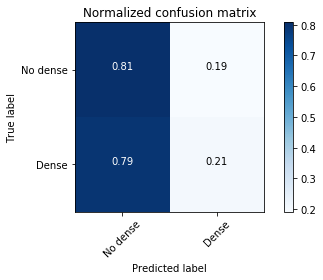

In [19]:
  
#confusion_matrix
cnf_matrix = confusion_matrix(y_test,rf.predict(X_test))
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


LDA
done in 1.821s
Average and std CV score : 0.5505644171740165 +- 0.002664627440148595
Score :  0.6023576498546012
 
Normalized confusion matrix
[[0.619 0.381]
 [0.529 0.471]]


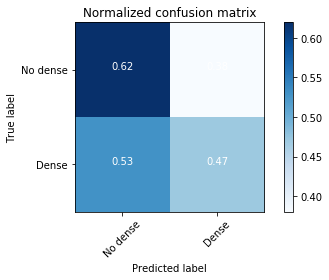

QDA
done in 0.678s
Average and std CV score : 0.5413977560664558 +- 0.0021372423073329314
Score :  0.6868140458397173
 
Normalized confusion matrix
[[0.732 0.268]
 [0.662 0.338]]


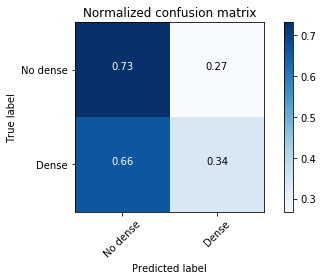

In [20]:
# LDA & QDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# LDA
print("LDA")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda_score = cross_val_score(lda,X=X_resampled, y=y_resampled,cv=5)
lda.fit(X_resampled,y_resampled)
print("done in %0.3fs" % (time() - t0))
print("Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))
print("Score : ",lda.score(X_test,y_test))
print(" ")

#confusion_matrix
y_pred = lda.predict(X_test)
cnf_matrix = confusion_matrix(y_test,y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


#QDA
print("QDA")
t0 = time()
qda = QuadraticDiscriminantAnalysis()
qda_score = cross_val_score(qda,X=X_resampled, y=y_resampled,cv=5)
qda.fit(X_resampled,y_resampled)
print("done in %0.3fs" % (time() - t0))
print("Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))
print("Score : ",qda.score(X_test,y_test))
print(" ")

#confusion_matrix
y_pred = qda.predict(X_test)
cnf_matrix = confusion_matrix(y_test,y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Decision Tree
{'min_samples_leaf': 18}
done in 346.809s
Average and std CV score : 0.8824118281225936 +- 0.0016765394314706113
Score :  0.8832744442012445
 
Normalized confusion matrix
[[0.997 0.003]
 [0.994 0.006]]


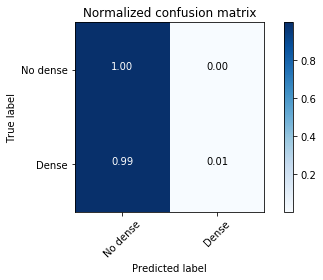

In [21]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

print("Decision Tree")
t0 = time()
Tree = DecisionTreeClassifier(criterion="gini",random_state=0,max_depth=10)
Tree.fit(X_train,y_train)
p_grid = {'min_samples_leaf': range(2,20)}
inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)
# Nested CV with parameter optimization
DT = GridSearchCV(estimator=Tree, param_grid=p_grid, cv=inner_cv)
DT.fit(X_train,y_train)
nested_score = cross_val_score(DT, X=X_train, y=y_train, cv=outer_cv)
print(DT.best_params_)
# Average accuracy
print("done in %0.3fs" % (time() - t0))
print("Average and std CV score : {0} +- {1}".format(nested_score.mean(), nested_score.std() ))
print("Score : ",DT.score(X_test,y_test))
print(" ")

#confusion_matrix
y_pred = DT.predict(X_test)
cnf_matrix = confusion_matrix(y_test,y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
# Bagging
from sklearn.ensemble import BaggingClassifier

print("Decision Tree with Bagging")


Tree2 = DecisionTreeClassifier(criterion="gini", min_samples_leaf=grid_tree.best_params_['min_samples_leaf'],  random_state=0,max_depth=5)
Tree2.fit(X_train, y_train)
p_grid_bagging = {'n_estimators': [500,1000]}      
bag=BaggingClassifier(base_estimator=Tree2, random_state=0, max_samples=0.5)

inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)
Bagg = GridSearchCV(estimator=bag, param_grid=p_grid_bagging, cv=inner_cv, scoring='precision')
nested_score = cross_val_score(Bagg, X=X_train, y=y_train,scoring="accuracy", cv=outer_cv)
Bagg.fit(X_train,y_train)
print("Average and std Cv score : {0} +- {1}".format(nested_score.mean(), nested_score.std() ))

grid_bag = GridSearchCV(estimator=bag, param_grid=p_grid_bagging, scoring="accuracy", cv=5)
grid_bag.fit(X_train, y_train)
print("Best Score: {}".format(grid_bag.best_score_))
print("Best params: {}".format(grid_bag.best_params_))
print("Score : ",grid_bag.score(X_test,y_test))
print(" ")

#confusion_matrix
y_pred = grid_bag.predict(X_test)
cnf_matrix = confusion_matrix(y_test,y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


#y = np.ravel(y_train)

In [29]:
# Non-Linear SVM
from sklearn.svm import SVC

# Non-linear SVM
print("Non-linear SVM")
t0 = time()
p_grid = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
svm = SVC(kernel = 'poly')
inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)
# Nested CV with parameter optimization
NLSVM = GridSearchCV(estimator=svm, param_grid=p_grid, cv=inner_cv)
nested_score = cross_val_score(NLSVM, X=X_train, y=y_train, cv=outer_cv)
NLSVM.fit(X_train,y_train)
print("done in %0.3fs" % (time() - t0))
print("Average and std Nested Cv score : {0} +- {1}".format(nested_score.mean(), nested_score.std() ))
print("Score : ",NLSVM.score(X_test,y_test))
print(" ")
      
# confusion_matrix
y_pred=NLSVM.predict(X_test)
cnf_matrix = confusion_matrix(y_test,y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


Non-linear SVM


KeyboardInterrupt: 

In [ ]:
# features' importance
from sklearn.ensemble import ExtraTreesClassifier

ERT = ExtraTreesClassifier(n_estimators=1000, random_state=0)
ERT.fit(X_train, y_train)
importances = ERT.feature_importances_
#revers indices
indices = np.argsort(importances)[::-1]

''''
# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


plt.figure()
plt.title("Feature importances ERT")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

'''

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


In [ ]:
print
for f in range(X.shape[1]):
    print(str(f) + ". " + names[indices[f]] + str(fit.scores_[indices[f]]))
    if fit.scores_[indices[f]]>0.02:
        FeatureIndList.append(indices[f])
        
print(X[:,FeatureIndList].shape)